In [1]:
import pandas as pd
df = pd.read_csv("c:/data/customer/customer.csv")
df.columns

Index(['Int'l Plan', 'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls',
       'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins',
       'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge',
       'CustServ Calls', 'Churn'],
      dtype='object')

In [2]:
cols=["Int'l Plan", 'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls']
X=df[cols]
y=df['Churn']
y.value_counts()

0    2850
1     483
Name: Churn, dtype: int64

In [3]:
#언더샘플링
from imblearn.under_sampling import RandomUnderSampler
X_sample, y_sample = RandomUnderSampler(random_state=0).fit_resample(X, y)
X_samp = pd.DataFrame(data=X_sample,columns=cols )
y_samp = pd.DataFrame(data=y_sample,columns=['Churn'])
df_samp=pd.concat([X_samp,y_samp],axis=1)
df_samp['Churn'].value_counts()

0    483
1    483
Name: Churn, dtype: int64

In [4]:
X=df_samp[cols]
y=df_samp['Churn']

<AxesSubplot:>

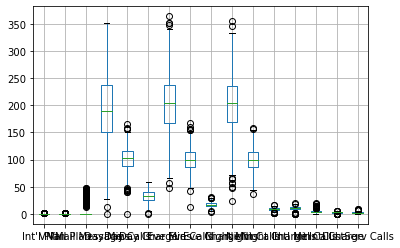

In [5]:
X.boxplot()


In [6]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
scaler.fit(X)
X_scaled = pd.DataFrame(scaler.transform(X))

<AxesSubplot:>

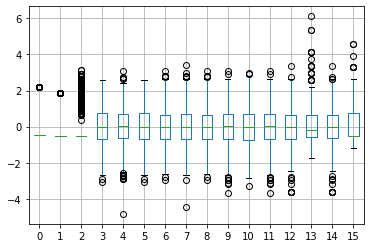

In [7]:
X_scaled.boxplot()

In [8]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
scaler.fit(X)
X_scaled = pd.DataFrame(scaler.transform(X))

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
import numpy as np
svm = SVC(random_state=0).fit(X, y)
#rf = RandomForestClassifier(random_state=0).fit(X, y)
# - 모형을 만드는데 사용된 변수들의 특성 중요도 트리 알고리즘에 더욱 적합한 방법
result = permutation_importance(svm, X, y, n_repeats=10, random_state=0,n_jobs=-1)
importances=np.array(list(zip(X.columns, result.importances_mean)))
df2=pd.DataFrame(importances)
df2


,0,1
0,Int'l Plan,0.0
1,VMail Plan,0.0
2,VMail Message,0.0023809523809523725
3,Day Mins,0.15186335403726708
4,Day Calls,0.0025879917184264854
5,Day Charge,0.00041407867494823724
6,Eve Mins,0.052380952380952375
7,Eve Calls,0.002277432712215344
8,Eve Charge,0.0008281573498964967
9,Night Mins,0.0025879917184264967


In [10]:
sorted_idx = result.importances_mean.argsort()
print(importances[sorted_idx[::-1]]) #넘파이 배열을 역순으로

[['Day Mins' '0.15186335403726708']
 ['Eve Mins' '0.052380952380952375']
 ['Intl Mins' '0.003209109730848847']
 ['Night Calls' '0.0026915113871635588']
 ['Night Mins' '0.0025879917184264967']
 ['Day Calls' '0.0025879917184264854']
 ['VMail Message' '0.0023809523809523725']
 ['Eve Calls' '0.002277432712215344']
 ['CustServ Calls' '0.001138716356107683']
 ['Intl Calls' '0.001138716356107683']
 ['Intl Charge' '0.0010351966873706209']
 ['Eve Charge' '0.0008281573498964967']
 ['Day Charge' '0.00041407867494823724']
 ['Night Charge' '0.0']
 ['VMail Plan' '0.0']
 ["Int'l Plan" '0.0']]


In [11]:
svm = SVC()
n_estimators = 10
model = BaggingClassifier(base_estimator=svm,
n_estimators=n_estimators,
max_samples=1/n_estimators,
n_jobs=-1)

In [12]:
import numpy as np
from sklearn.model_selection import cross_val_score
costs = np.logspace(-10, 3, 14) # 10의 -10승부터 10의 3승까지 14개의 구간
scores = []
for c in costs:
    model.base_estimator.C = c # 분류기의 C 파라미터
    #교차검증
    this_scores = cross_val_score(model, X_scaled, y, n_jobs=2, cv=3) # 3회 교차검증
    m=np.mean(this_scores)
    print(c,'==>',m)
    scores.append(m)
print('max:',max(scores))
print('idx:',np.argmax(scores))
print('C:',costs[np.argmax(scores)])

1e-10 ==> 0.5579710144927535
1e-09 ==> 0.5703933747412008
1e-08 ==> 0.5
1e-07 ==> 0.556935817805383
1e-06 ==> 0.6304347826086957
1e-05 ==> 0.6118012422360248
0.0001 ==> 0.5693581780538303
0.001 ==> 0.562111801242236
0.01 ==> 0.5
0.1 ==> 0.5
1.0 ==> 0.7950310559006212
10.0 ==> 0.7857142857142857
100.0 ==> 0.8043478260869565
1000.0 ==> 0.7877846790890269
max: 0.8043478260869565
idx: 12
C: 100.0


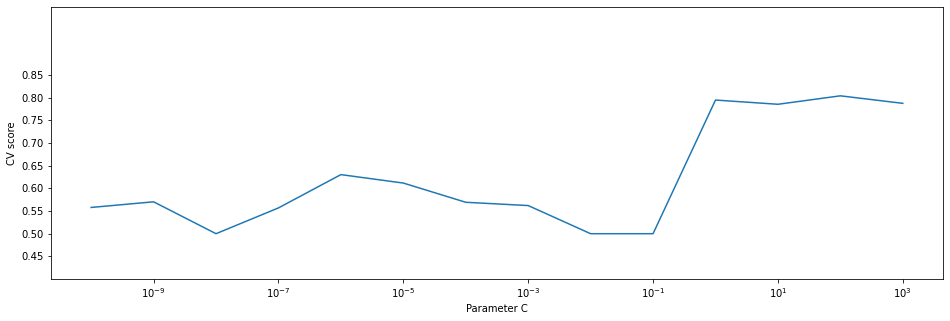

In [13]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=(16,5)
plt.semilogx(costs, scores)
locs, labels = plt.yticks()
plt.yticks(locs)
plt.ylabel('CV score')
plt.xlabel('Parameter C')
plt.ylim(0.4, 1)
plt.show()